# Preprocessing Notebook # 1

### 1. Feature Selection
Remove redundant or insignificant features

### 2. Transformations
Data type conversions

### 3. Missing values
How many missing values were there in the transactions dataset

### 4. Outlier Detection
Any values outside the range (negative, min/max)
Any instances with unreasonable value.

In [1]:
# Run this script once
%run ../scripts/ETL.py

23/10/20 13:25:03 WARN Utils: Your hostname, Keigos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.237.109 instead (on interface en0)
23/10/20 13:25:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/20 13:25:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/20 13:25:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/20 13:25:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/20 13:25:17 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

In [3]:
# Read the dataset
data = spark.read.parquet('../data/raw/transactions_data/')
print(f'Total number of instances: {data.count()}')
data.show(2)

Total number of instances: 14195505
+------------+--------------+-------+------------------+--------------------+-----------+--------------------+------------------+-----+--------+------+-------------------+--------------------+--------------------+-------------+--------------------+------------------+-------------------+
|merchant_abn|order_datetime|user_id|      dollar_value|            order_id|consumer_id|       consumer_name|           address|state|postcode|gender|consumer_fraud_prob|       merchant_name|                tags|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|
+------------+--------------+-------+------------------+--------------------+-----------+--------------------+------------------+-----+--------+------+-------------------+--------------------+--------------------+-------------+--------------------+------------------+-------------------+
| 10648956813|    2022-07-30|  16481|61.909622443779654|c80b4dc3-056e-4fa...|     499986|           

## Join external dataset

In [4]:
consumer_external = spark.read.format("csv") \
                .options(header=True, delimiter=",") \
                .load('../data/raw/addedInfo_transaction/tbl_consumer_demo_income.csv') \
                .withColumnRenamed("name", "consumer_name")
data = data.join(consumer_external, 
                 on=['consumer_id', 'consumer_name', 'address', 'state', 'postcode', 'gender'], 
                 how='inner')

## Feature Selection

In [5]:
# drop unnecessary columns
dropping_cols = ('user_id', 'consumer_name', 'address', 'ERPchange#', 'ERPchange%', 'mean_income', 'SA2_NAME21', 'SA2_CODE21', 'Area', 'tags')
data = data.drop(*dropping_cols)
data.show(2)

+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+-------+-------+--------------+-------------+--------------------+-----------+-----------------+-----------+-------------+
|consumer_id|state|postcode|gender|merchant_abn|order_datetime|      dollar_value|            order_id|consumer_fraud_prob|       merchant_name|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|2021ERP|2022ERP|popDensity2022|SA2_CODE_2021|       SA2_NAME_2021|num_earners|medianAge_earners| sum_income|median_income|
+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+-------+-------+--------------+-------------+--------------------+-----------+-----------------+----

## Transformation - Data Type Conversions
Since the dataset comes from multiple sources, we need to ensure all columns have correct data types. Most features had string type so we need to perform data type conversions.

In [6]:
data = data \
    .withColumn('consumer_id', col('consumer_id').cast(IntegerType())) \
    .withColumn('postcode', col('postcode').cast(IntegerType())) \
    .withColumn('2021ERP', col('2021ERP').cast(IntegerType())) \
    .withColumn('2022ERP', col('2022ERP').cast(IntegerType())) \
    .withColumn('popDensity2022', col('popDensity2022').cast(FloatType())) \
    .withColumn('num_earners', col('num_earners').cast(IntegerType())) \
    .withColumn('medianAge_earners', col('medianAge_earners').cast(FloatType())) \
    .withColumn('sum_income', col('sum_income').cast(FloatType())) \
    .withColumn('median_income', col('median_income').cast(FloatType())) \
    .withColumn('consumer_fraud_prob', col('consumer_fraud_prob').cast(FloatType())) \
    .withColumn('merchant_fraud_prob', col('merchant_fraud_prob').cast(FloatType()))

In [7]:
data.printSchema()

root
 |-- consumer_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_fraud_prob: float (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_desc: string (nullable = true)
 |-- merchant_revenue_lvl: string (nullable = true)
 |-- merchant_take_rate: float (nullable = true)
 |-- merchant_fraud_prob: float (nullable = true)
 |-- 2021ERP: integer (nullable = true)
 |-- 2022ERP: integer (nullable = true)
 |-- popDensity2022: float (nullable = true)
 |-- SA2_CODE_2021: string (nullable = true)
 |-- SA2_NAME_2021: string (nullable = true)
 |-- num_earners: integer (nullable = true)
 |-- medianAge_earners: float (nullable = true)
 |-- sum_income: float (nullable = true)
 |-- median_income: float 

## Feature Engineering

In [8]:
data = data \
    .withColumn("year", year("order_datetime")) \
    .withColumn("month", month("order_datetime"))

In [9]:
data = data.withColumn(
    "population",
    when(col("year") == 2021, col("2021ERP")) \
    .when(col("year") == 2022, col("2022ERP")) \
    .otherwise(0)
)
data = data.drop('2021ERP', '2022ERP')

In [10]:
data.show(2)

+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+--------------+-------------+--------------------+-----------+-----------------+-----------+-------------+----+-----+----------+
|consumer_id|state|postcode|gender|merchant_abn|order_datetime|      dollar_value|            order_id|consumer_fraud_prob|       merchant_name|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|popDensity2022|SA2_CODE_2021|       SA2_NAME_2021|num_earners|medianAge_earners| sum_income|median_income|year|month|population|
+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+--------------+-------------+--------------------+-----------+-----------------+--------

## Missing values

In [11]:
columns_to_inspect = data.columns
columns_to_inspect.remove('order_datetime')
data.select([count(when(col(c).isNull(), c)).alias(c) for c in columns_to_inspect]).show()
# data.select([count(when(col(c).contains('None') | \
#                             col(c).contains('NULL') | \
#                             (col(c) == '' ) | \
#                             col(c).isNull() | \
#                             isnan(c), c 
#                            )).alias(c)
#                     for c in columns]).show()

+-----------+-----+--------+------+------------+------------+--------+-------------------+-------------+-------------+--------------------+------------------+-------------------+--------------+-------------+-------------+-----------+-----------------+----------+-------------+----+-----+----------+
|consumer_id|state|postcode|gender|merchant_abn|dollar_value|order_id|consumer_fraud_prob|merchant_name|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|popDensity2022|SA2_CODE_2021|SA2_NAME_2021|num_earners|medianAge_earners|sum_income|median_income|year|month|population|
+-----------+-----+--------+------+------------+------------+--------+-------------------+-------------+-------------+--------------------+------------------+-------------------+--------------+-------------+-------------+-----------+-----------------+----------+-------------+----+-----+----------+
|          0|    0|       0|     0|           0|           0|       0|           14115157|       580830

There are 580830 instances with no merchant information. Since we are ranking the merchants, any transaction without any merchant information is not useful for our final ranking system. If we do not have information about that merchant, then that merchant is likely to not be our client. Therefore, we are removing those instances. 

In addition, there are many instances with no fraud probability values. Since we train specific machine learning model for the fraud features, we don't need to impute the missing values for fraud features for now.

In [12]:
filtered = data.filter(col('merchant_name').isNotNull())
null_data = data.filter(col('merchant_name').isNull())

In [13]:
null_data.agg(*[countDistinct(col('merchant_abn')).alias('# of merchants without any information')]).show()

+--------------------------------------+
|# of merchants without any information|
+--------------------------------------+
|                                   396|
+--------------------------------------+



In [14]:
filtered.agg(*[countDistinct(col('merchant_abn')).alias('# of merchants with information')]).show()

+-------------------------------+
|# of merchants with information|
+-------------------------------+
|                           4026|
+-------------------------------+



In [15]:
filtered.select([count(when(col(c).isNull(), c)).alias(c) for c in filtered.columns]).show()

+-----------+-----+--------+------+------------+--------------+------------+--------+-------------------+-------------+-------------+--------------------+------------------+-------------------+--------------+-------------+-------------+-----------+-----------------+----------+-------------+----+-----+----------+
|consumer_id|state|postcode|gender|merchant_abn|order_datetime|dollar_value|order_id|consumer_fraud_prob|merchant_name|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|popDensity2022|SA2_CODE_2021|SA2_NAME_2021|num_earners|medianAge_earners|sum_income|median_income|year|month|population|
+-----------+-----+--------+------+------------+--------------+------------+--------+-------------------+-------------+-------------+--------------------+------------------+-------------------+--------------+-------------+-------------+-----------+-----------------+----------+-------------+----+-----+----------+
|          0|    0|       0|     0|           0|          

Now, there is no missing data in the dataset except for fraud probabilities

## Invalid records detection

In [16]:
# filter out transactions with negative value or out of relavant range
invalid_count = filtered.filter((col('dollar_value') < 0) |
                                (col('consumer_id') < 0) |
                                (col('postcode') < 0) |
                                (col('merchant_take_rate') < 0) |
                                (col('merchant_take_rate') > 100) |
                                (col('merchant_fraud_prob') < 0) |
                                (col('merchant_fraud_prob') > 100) |  
                                (col('consumer_fraud_prob') < 0) | 
                                (col('consumer_fraud_prob') > 100)
                                ).count()
print(f'There are {invalid_count} instances with invalid numerical values.')

There are 0 instances with invalid numerical values.


In [17]:
# check whether the transactions are contained within the predefined timeframe
BEGIN_DATE = "2021-02-28"
END_DATE = "2022-08-28"
out_range = filtered.filter(~(col('order_datetime').between(BEGIN_DATE, END_DATE)))
before_range = filtered.filter((col('order_datetime') < BEGIN_DATE))
after_range = filtered.filter((col('order_datetime') > END_DATE))
print(f'There are {before_range.count()} instances before 2021-02-28 and {after_range.count()} instances after 2022-08-28.')
print(f'In total, there are {out_range.count()} instances outside our specified range.')

out_range.show(5)

There are 0 instances before 2021-02-28 and 1567358 instances after 2022-08-28.


In total, there are 1567358 instances outside our specified range.


+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+--------------+-------------+--------------------+-----------+-----------------+-----------+-------------+----+-----+----------+
|consumer_id|state|postcode|gender|merchant_abn|order_datetime|      dollar_value|            order_id|consumer_fraud_prob|       merchant_name|merchant_desc|merchant_revenue_lvl|merchant_take_rate|merchant_fraud_prob|popDensity2022|SA2_CODE_2021|       SA2_NAME_2021|num_earners|medianAge_earners| sum_income|median_income|year|month|population|
+-----------+-----+--------+------+------------+--------------+------------------+--------------------+-------------------+--------------------+-------------+--------------------+------------------+-------------------+--------------+-------------+--------------------+-----------+-----------------+--------

There are 1567358 instances that are outside our datetime range. All of the instances outside the range are dated after 2022-08-28. Although it is outside our specified range, we are retaining these instances.

In [18]:
# get descriptive statistics for numerical features
numerical_columns = ['dollar_value', 'popDensity2022', 'population', 
                     'num_earners', 'medianAge_earners', 'sum_income', 
                     'median_income', 'merchant_take_rate']
filtered.describe(numerical_columns).show()

23/10/20 13:26:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|summary|        dollar_value|    popDensity2022|        population|      num_earners| medianAge_earners|          sum_income|     median_income|merchant_take_rate|
+-------+--------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|  count|            13614675|          13614675|          13614675|         13614675|          13614675|            13614675|          13614675|          13614675|
|   mean|  158.43608405018054|1073.8380993153958|10455.684719539762|6782.159867202118|44.933916233769814| 5.083780887499887E8| 51109.26665649382| 4.588886960094146|
| stddev|   461.4935000146336|2135.3645470581823| 6433.840502722946|5168.659116963277| 4.972648523635417|5.2382917373695606E8|11524.264350327174|1.7384891948563357|
|    min|9

For dollar values, we have very small values that don't make sense. Since any transaction amount can't be less than a cent, we are putting the minimum threshold of 0.01 on dollar values. In the distribution of these suspicious transactions, however, may be hidden patterns about some merchants. For example, some merchants may be creating these transactions with small values to artificially raise the performance measures of the business. Therefore, we need to consider them separately.

In [19]:
# print out number of merchants that are making transactions with revenue less than a cent
small_values = filtered.filter(col('dollar_value') < 0.01)
print(f'There are {small_values.count()} instances with very small dollar values.')
small_values.agg(countDistinct(col('merchant_abn')).alias('# of merchants with suspicious transactions')).show()

There are 1014 instances with very small dollar values.


+-------------------------------------------+
|# of merchants with suspicious transactions|
+-------------------------------------------+
|                                        177|
+-------------------------------------------+



In [20]:
# print out hows many small transactions those merchants are making
small_merchants = small_values.groupBy('merchant_abn') \
    .agg(count('merchant_abn').alias('num_small_valued_transactions'))
small_merchants.sort(col('num_small_valued_transactions').desc()).show(10)

+------------+-----------------------------+
|merchant_abn|num_small_valued_transactions|
+------------+-----------------------------+
| 63290521567|                           77|
| 46804135891|                           72|
| 45629217853|                           68|
| 80324045558|                           53|
| 20985347699|                           51|
| 19933438190|                           50|
| 91923722701|                           50|
| 17324645993|                           46|
| 80682333501|                           29|
| 70038202360|                           19|
+------------+-----------------------------+
only showing top 10 rows



We have found out that these merchants have a lot of transactions with unusually small dollar values. Compared to the number of transactions that we have across the timeframe, the number of transactions with small values are very small.

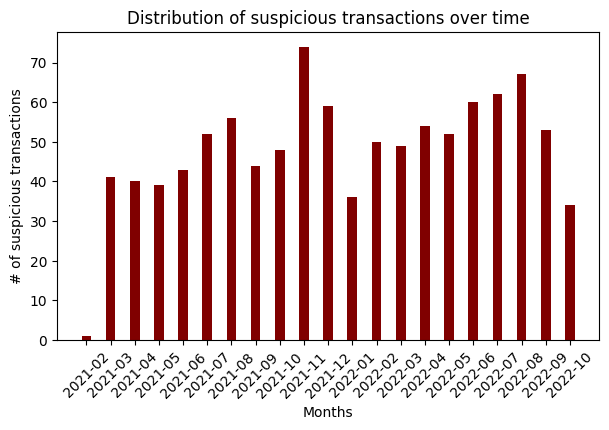

In [21]:
small_values = small_values.withColumn("year_month", date_format(small_values["order_datetime"], "yyyy-MM"))

# Group by the 'year_month' column and count the occurrences in each group
small_dates = small_values.groupBy("year_month").agg(count("*").alias("count")).sort(col('year_month')).toPandas()

fig = plt.figure(figsize = (7, 4))
plt.bar(small_dates['year_month'], small_dates['count'], color ='maroon',
        width = 0.4)
plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("# of suspicious transactions")
plt.title("Distribution of suspicious transactions over time")
plt.savefig('../plots/dist_small_values.png', bbox_inches='tight')
plt.show()

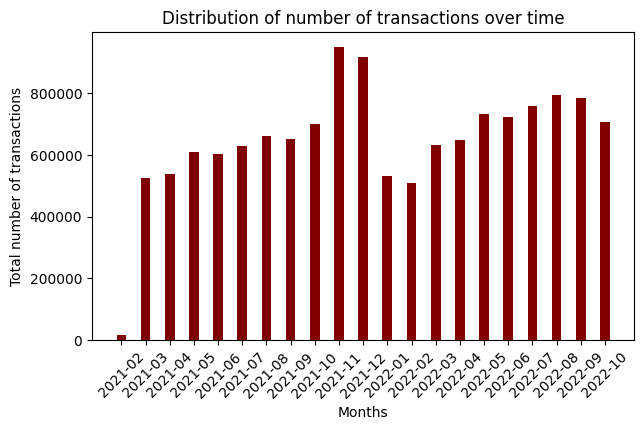

In [22]:
monthly_grouped = filtered.withColumn("year_month", date_format(small_values["order_datetime"], "yyyy-MM"))
monthly_data = monthly_grouped.groupBy("year_month").agg(count("*").alias("count")).sort(col('year_month')).toPandas()
fig = plt.figure(figsize = (7, 4))
plt.bar(monthly_data['year_month'], monthly_data['count'], color ='maroon',
        width = 0.4)
plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("Total number of transactions")
plt.title("Distribution of number of transactions over time")
plt.savefig('../plots/dist_total_transactions.png', bbox_inches='tight')
plt.show()

The distribution of suspicious transactions follow that of all transactions. Since there is no special trend, we conclude that the suspicious transactions probably emerged from human errors. Thus, we are removing all transactions with dollar_value less than 0.01.

In [23]:
filtered = filtered.filter(col('dollar_value') >= 0.01)
print(f'We have removed {small_values.count()} instances and we are left with {filtered.count()} instances.')

We have removed 1014 instances and we are left with 13613661 instances.


In [24]:
filtered \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet("../data/raw/transactions_clean")